In [42]:
import pickle
import numpy as np
import xgboost as xgb

In [43]:
np.random.seed(2026)

In [44]:
# Define median-based ensemble of surrogates
class medClassifier:
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def predict(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            try:
                self.predictions_.append(classifier.predict(X)) #used for the random forest that is part of the ensemble
            except:
                X = xgb.DMatrix(X)
                self.predictions_.append(classifier.predict(X)) #used for the XGBoost models that are part of the ensemble
        med1 = np.median(self.predictions_, axis=0) #median of predictions
        mean1 = np.mean(self.predictions_, axis=0) #mean of predictions
        out = med1 + np.random.rand()*np.abs(med1-mean1) #add more noise if median is far from mean, indicating more uncertainty, also all noise is positive to focus on minimizing parts with more certainty
        return out

In [45]:
# Load Ensemble
#Ensemblefile = os.path.join(folder_path,"Ensemble.pkl")
Ensemblefile = "Ensemble.pkl"
with open(Ensemblefile, 'rb') as file:
    Ensemble = pickle.load(file)


#This is the first objective function
def objective1(x):
    x = np.array([x])
    pred = Ensemble.predict(x)
    return pred[0]

In [46]:
from scipy.stats import truncnorm

# Build second objective
rotor_diameter = 126 # in meters
farm_length = 333.33*5 # in meters

def objective2(x):

    x = np.array([x])
    coords = np.resize(x,(2,5)) # wind turbine coordinates

    # Use a Monte Carlo simulation for the birds, who all fly from top to bottom at an x-location with a normal distribution. The mean of the normal distribution is far to the left of the wind farm.
    bird_mean = -25000 #width of bird corridor is 50km
    x_sigma = 4 # assume this many sigma of birds to stay within the planned corridor
    bird_std = (25000/x_sigma)
    #simulate birds (location in meters)
    nr_birds = 1000 # number of birds
    birds = truncnorm.rvs(x_sigma,
                          x_sigma+farm_length/bird_std,
                          loc=bird_mean,
                          scale=bird_std,
                          size=nr_birds,
                          random_state=2026 # fix the random seed
                         ) # Uses a truncated normal distribution, only sampling in the wind farm, not the entire bird corridor

    #check how many birds are close to a wind turbine (everything right of the leftmost turbine - rotor_diameter is dangerous area)
    leftmost = np.min(coords[0]) #location of leftmost turbine, in [0,1] units
    leftmost = leftmost*farm_length #change to meters
    threshold = leftmost-rotor_diameter #threshold of where the dangerous area starts (from left to right)

    close_birds = np.sum(birds >= threshold)/nr_birds #check how many birds fly to the right of the threshold
    return close_birds


In [47]:
# Build the constraint

from scipy.spatial.distance import cdist

def constraint1(x):
    coords = np.resize(x,(5,2))
    min_dist = 999999 #minimum distance between turbines (Euclidean)

    for turb in range(4):
        dists = cdist([coords[turb]],coords[turb+1:])
        next_min = np.min(dists)
        if next_min < min_dist:
            min_dist = next_min
    # if min_dist*farm_length < 2*rotor_diameter:
    #     constr = 0 # constraint not satisfied, wind turbines are too close to each other
    # else:
    #     constr = 1 # constraint satisfied
    
    cv = 2*rotor_diameter - min_dist*farm_length # constraint violation: <=0 is feasible and >0 is infeasible
    
    return cv

 

In [48]:
# test objectives and constraints
x3 = x1 = [0.29, 0.4871309875290023, 0.54153605985017246, 0.2954912222384124, 0.9558389075666868, 0.1992480932223422, 0.5400992985215289, 0.14902261675540462, 0.7592757901802544, 0.9586]
print(objective1(x3))
print(objective2(x3))
print(constraint1(x3))

-50.14358
0.709
7.876354330066846


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

N_VAR = 10
N_EVAL = 500
POP_SIZE = 50
SEED = 2026


class P(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=N_VAR, n_obj=2, n_constr=1,
                         xl=np.zeros(N_VAR), xu=np.ones(N_VAR))

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = [objective1(x), objective2(x)]
        out["G"] = [constraint1(x)]


# Collect all evaluated solutions (as much as possible) during the run
class MyCallback(Callback):
    def __init__(self):
        super().__init__()
        self.X = []
        self.F = []
        self.G = []
        self._added_initial_pop = False

    def notify(self, algorithm):
        # Add initial population once
        if not self._added_initial_pop:
            pop = algorithm.pop
            self.X.append(pop.get("X"))
            self.F.append(pop.get("F"))
            self.G.append(pop.get("G"))
            self._added_initial_pop = True

        # Add offspring evaluated in this generation (main source of new evals)
        off = getattr(algorithm, "off", None)
        if off is not None and len(off) > 0:
            self.X.append(off.get("X"))
            self.F.append(off.get("F"))
            self.G.append(off.get("G"))


cb = MyCallback()

res = minimize(
    P(),
    NSGA2(pop_size=POP_SIZE),
    termination=("n_eval", N_EVAL),
    seed=SEED,
    callback=cb,
    verbose=False
)

# ---- build dataframe (trim to first N_EVAL rows) ----
X_all = np.vstack(cb.X) if len(cb.X) else np.empty((0, N_VAR))
F_all = np.vstack(cb.F) if len(cb.F) else np.empty((0, 2))
G_all = np.vstack(cb.G) if len(cb.G) else np.empty((0, 1))

n = min(N_EVAL, len(X_all))
X_all, F_all, G_all = X_all[:n], F_all[:n], G_all[:n]

cv = G_all[:, 0]               # constraint violation (<=0 feasible)
feasible = (cv <= 0)

# df = pd.DataFrame(X_all, columns=[f"x{i}" for i in range(N_VAR)])
df = pd.DataFrame(columns=["obj1", "obj2", "cv", "feasible"])
df["obj1"] = F_all[:, 0]
df["obj2"] = F_all[:, 1]
df["cv"] = cv
df["feasible"] = feasible.astype(int)

df.to_csv("nsga2_results.csv", index=False)

feasible_rate = 0.638 (319/500)


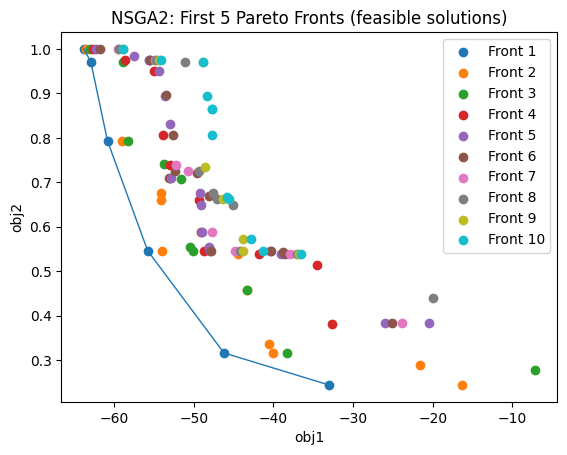

In [51]:
# ---- feasible rate ----
feasible_rate = df["feasible"].mean()
print("feasible_rate =", feasible_rate, f"({df['feasible'].sum()}/{len(df)})")

# ---- non-dominated sorting on feasible only ----
feas = df[df["feasible"] == 1].copy()
if len(feas) == 0:
    print("No feasible solutions -> cannot do Pareto fronts plot.")
else:
    F = feas[["obj1", "obj2"]].to_numpy()

    fronts = NonDominatedSorting().do(F)

    # store rank (front index + 1)
    rank = np.empty(len(feas), dtype=int)
    for i, front in enumerate(fronts):
        rank[front] = i + 1
    feas["rank"] = rank

    # ---- plot first 5 fronts ----
    plt.figure()

    MAX_FRONTS = 10
    for i, front in enumerate(fronts[:MAX_FRONTS]):
        pts = F[front]
        plt.scatter(pts[:, 0], pts[:, 1], label=f"Front {i+1}")

    # connect best front by a line
    best = F[fronts[0]]
    best = best[np.argsort(best[:, 0])]
    plt.plot(best[:, 0], best[:, 1], linewidth=1)

    plt.xlabel("obj1")
    plt.ylabel("obj2")
    plt.title("NSGA2: First 5 Pareto Fronts (feasible solutions)")
    plt.legend()
    plt.savefig("pareto_fronts_nsga2.png", dpi=300, bbox_inches="tight")
    plt.show()

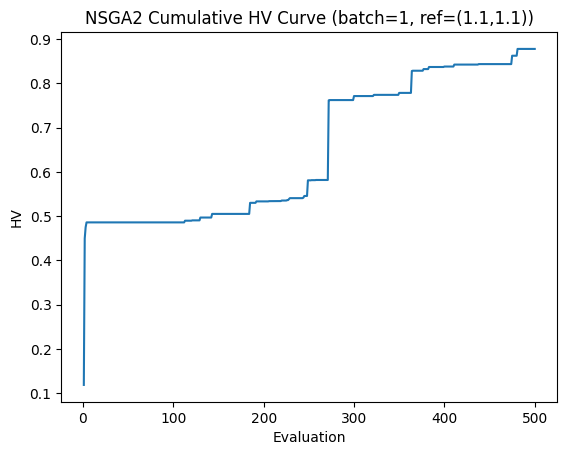

Saved: hv_curve_nsga2_cumulative.png


In [59]:
import matplotlib.pyplot as plt

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV

CSV_PATH = "nsga2_results.csv"
BATCH_SIZE = 1
REF_POINT = np.array([1.1, 1.1], dtype=float)

df = pd.read_csv(CSV_PATH)


f_min = np.array([-67.83963013,   0.153], dtype=float)
f_max = np.array([-0.77212131,  1.0], dtype=float)

denom = f_max - f_min
denom[denom == 0] = 1.0

hv_indicator = HV(ref_point=REF_POINT)

xs, hvs = [], []

n = len(df)
for end in range(BATCH_SIZE, n + 1, BATCH_SIZE):
    cur = df.iloc[:end]
    cur_feas = cur[cur["feasible"] == 1]

    xs.append(end)

    if len(cur_feas) == 0:
        hvs.append(0.0)
        continue

    F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)

    fronts = NonDominatedSorting().do(F)
    F_best = F[fronts[0]]

    F_best_norm = (F_best - f_min) / denom

    hv_value = float(hv_indicator(F_best_norm))
    hvs.append(hv_value)

if n % BATCH_SIZE != 0:
    end = n
    cur = df.iloc[:end]
    cur_feas = cur[cur["feasible"] == 1]
    xs.append(end)

    if len(cur_feas) == 0:
        hvs.append(0.0)
    else:
        F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)
        fronts = NonDominatedSorting().do(F)
        F_best = F[fronts[0]]
        F_best_norm = (F_best - f_min) / denom
        hvs.append(float(hv_indicator(F_best_norm)))

plt.figure()
plt.plot(xs, hvs)
plt.xlabel("Evaluation")
plt.ylabel("HV")
plt.title(f"NSGA2 Cumulative HV Curve (batch={BATCH_SIZE}, ref=(1.1,1.1))")
plt.savefig("hv_curve_nsga2_cumulative.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: hv_curve_nsga2_cumulative.png")

In [55]:

files = [
    "random_search_results.csv",
    "nsga2_results.csv",
    "ehvi_results.csv",
]

all_feas = []

for f in files:
    df = pd.read_csv(f)
    feas = df[df["feasible"] == 1][["obj1", "obj2"]]
    all_feas.append(feas)

all_feas = pd.concat(all_feas, ignore_index=True)

F = all_feas.to_numpy(dtype=float)

f_min = F.min(axis=0)
f_max = F.max(axis=0)

print("f_min =", f_min)
print("f_max =", f_max)

f_min = [-64.26302338   0.153     ]
f_max = [-0.77212131  1.        ]


Random Search feasible_rate = 0.498 (249/500)
NSGA2 feasible_rate        = 0.638 (319/500)
EHVI feasible_rate        = 0.49 (245/500)


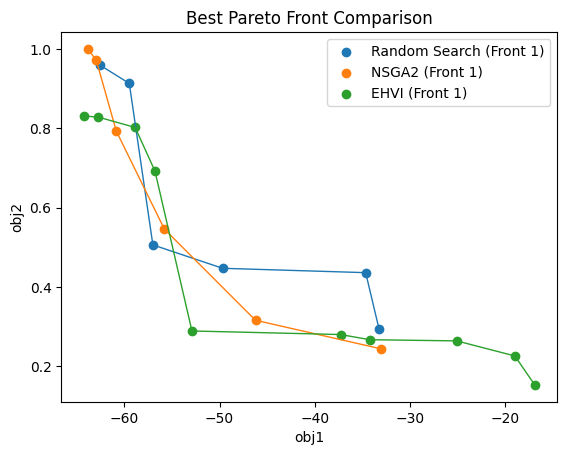

saved pareto_front_comparison.png


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def get_best_front(csv_path):
    df = pd.read_csv(csv_path)
    feas = df[df["feasible"] == 1].copy()
    if len(feas) == 0:
        return None, df

    F = feas[["obj1", "obj2"]].to_numpy(dtype=float)
    fronts = NonDominatedSorting().do(F)
    best = F[fronts[0]]

    # sort for a nice connected line (by obj1)
    best = best[np.argsort(best[:, 0])]
    return best, df

# ---- read + get best fronts ----
F_rs, df_rs = get_best_front("random_search_results.csv")
F_nsga, df_nsga = get_best_front("nsga2_results.csv")
F_ehvi, df_ehvi = get_best_front("ehvi_results.csv")

# ---- print feasible rates ----
print("Random Search feasible_rate =", df_rs["feasible"].mean(), f"({df_rs['feasible'].sum()}/{len(df_rs)})")
print("NSGA2 feasible_rate        =", df_nsga["feasible"].mean(), f"({df_nsga['feasible'].sum()}/{len(df_nsga)})")
print("EHVI feasible_rate        =", df_ehvi["feasible"].mean(), f"({df_ehvi['feasible'].sum()}/{len(df_ehvi)})")

# ---- plot ----
plt.figure()

if F_rs is not None:
    plt.scatter(F_rs[:, 0], F_rs[:, 1], label="Random Search (Front 1)")
    plt.plot(F_rs[:, 0], F_rs[:, 1], linewidth=1)

if F_nsga is not None:
    plt.scatter(F_nsga[:, 0], F_nsga[:, 1], label="NSGA2 (Front 1)")
    plt.plot(F_nsga[:, 0], F_nsga[:, 1], linewidth=1)

if F_ehvi is not None:
    plt.scatter(F_ehvi[:, 0], F_ehvi[:, 1], label="EHVI (Front 1)")
    plt.plot(F_ehvi[:, 0], F_ehvi[:, 1], linewidth=1)

plt.xlabel("obj1")
plt.ylabel("obj2")
plt.title("Best Pareto Front Comparison")
plt.legend()
plt.savefig("pareto_front_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("saved pareto_front_comparison.png")

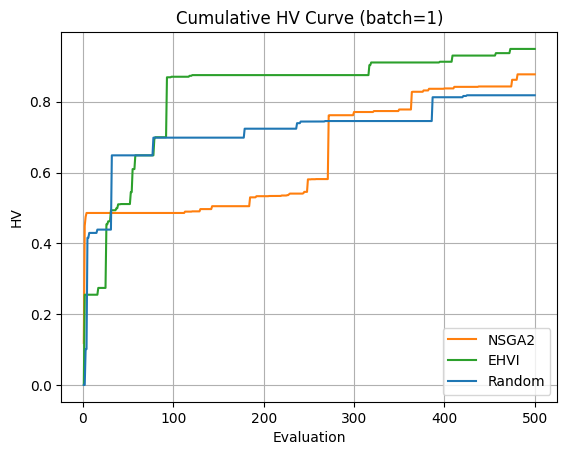

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV


BATCH_SIZE = 1
REF_POINT = np.array([1.1, 1.1], dtype=float)

CSV_PATHS = {
    "NSGA2": "nsga2_results.csv",
    "EHVI": "ehvi_results.csv",
    "Random": "random_search_results.csv",
}

# Normalization bounds (use the SAME bounds for all algorithms)
f_min = np.array([-67.83963013, 0.153], dtype=float)
f_max = np.array([-0.77212131, 1.0], dtype=float)

denom = f_max - f_min
denom[denom == 0] = 1.0

hv_indicator = HV(ref_point=REF_POINT)



def compute_hv_curve(csv_path: str):
    df = pd.read_csv(csv_path)

    xs, hvs = [], []
    n = len(df)

    for end in range(BATCH_SIZE, n + 1, BATCH_SIZE):
        cur = df.iloc[:end]
        cur_feas = cur[cur["feasible"] == 1]

        xs.append(end)

        if len(cur_feas) == 0:
            hvs.append(0.0)
            continue

        F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)

        fronts = NonDominatedSorting().do(F)
        F_best = F[fronts[0]]

        F_best_norm = (F_best - f_min) / denom
        hv_value = float(hv_indicator(F_best_norm))
        hvs.append(hv_value)

    # handle final remainder (< BATCH_SIZE)
    if n % BATCH_SIZE != 0:
        end = n
        cur = df.iloc[:end]
        cur_feas = cur[cur["feasible"] == 1]
        xs.append(end)

        if len(cur_feas) == 0:
            hvs.append(0.0)
        else:
            F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)
            fronts = NonDominatedSorting().do(F)
            F_best = F[fronts[0]]
            F_best_norm = (F_best - f_min) / denom
            hvs.append(float(hv_indicator(F_best_norm)))

    return xs, hvs



plt.figure()

color_map = {
    "Random": "C0",   
    "NSGA2": "C1",    
    "EHVI": "C2",     
}

for label, path in CSV_PATHS.items():
    xs, hvs = compute_hv_curve(path)
    plt.plot(xs, hvs, label=label, color=color_map[label])

plt.xlabel("Evaluation")
plt.ylabel("HV")
plt.title(f"Cumulative HV Curve (batch={BATCH_SIZE})")
plt.legend()
plt.grid(True)

plt.savefig("hv_curve_all_algorithms.png", dpi=300, bbox_inches="tight")
plt.show()